In [1]:
# imports from Qiskit
from numpy import pi
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import random
import numpy as np

In [2]:
import qiskit as qk
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit import IBMQ
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# imports from backend providers (IBM for superconductor, AQT for trapped ion)
from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aqt import AQT

ibmq_provider = IBMQ.load_account()        # credentials stored on disk
aqt_provider_simulators = AQT.enable_account('2633b2d14dae4d9da7c9df2503857334')  # simulator credentials
# aqt_provider_device = AQT.enable_account('INPUT DEVICE CREDENTIALS HERE') # hardware credentials

ibmq_simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
ibmq_device = ibmq_provider.get_backend('ibmq_burlington')
aqt_simulator = aqt_provider_simulators.get_backend('aqt_qasm_simulator')
# calling noisy simulator the 'device' for now
aqt_device = aqt_provider_simulators.get_backend('aqt_qasm_simulator_noise_1')

# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x,
                    'y':quantum_circuit.y,
                    'z':quantum_circuit.z,
                    'h':quantum_circuit.h,                    
                    't':quantum_circuit.t,                    
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg
    
    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]]

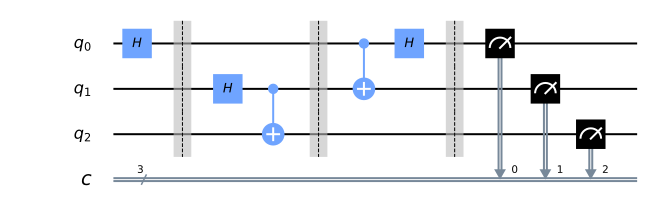

In [3]:
secret_unitary = 'h'
n = 3
qc1 = QuantumCircuit(n, n)
apply_secret_unitary(secret_unitary, qc1.qubits[0], qc1, dagger = 0)
qc1.barrier()
qc1.h(1)
qc1.cx(1,2)
qc1.barrier()
qc1.cx(0,1)
qc1.h(0)
qc1.barrier()
qc1.measure([0,1,2],[0,1,2])
qc1.draw(output='mpl')

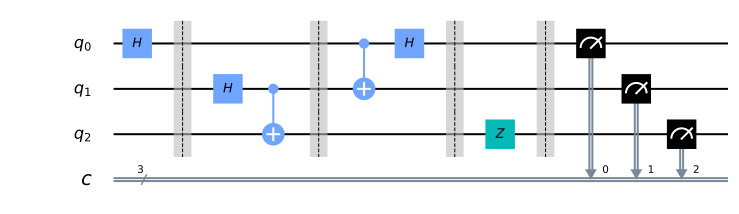

In [4]:
qc2 = QuantumCircuit(n, n)
apply_secret_unitary(secret_unitary, qc2.qubits[0], qc2, dagger = 0)
qc2.barrier()
qc2.h(1)
qc2.cx(1,2)
qc2.barrier()
qc2.cx(0,1)
qc2.h(0)
qc2.barrier()
qc2.z(2)
qc2.barrier()
qc2.measure([0,1,2],[0,1,2])
qc2.draw(output='mpl')

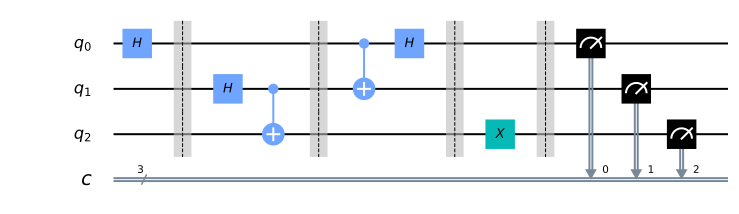

In [5]:
qc3 = QuantumCircuit(n, n)
apply_secret_unitary(secret_unitary, qc3.qubits[0], qc3, dagger = 0)
qc3.barrier()
qc3.h(1)
qc3.cx(1,2)
qc3.barrier()
qc3.cx(0,1)
qc3.h(0)
qc3.barrier()
qc3.x(2)
qc3.barrier()
qc3.measure([0,1,2],[0,1,2])
qc3.draw(output='mpl')

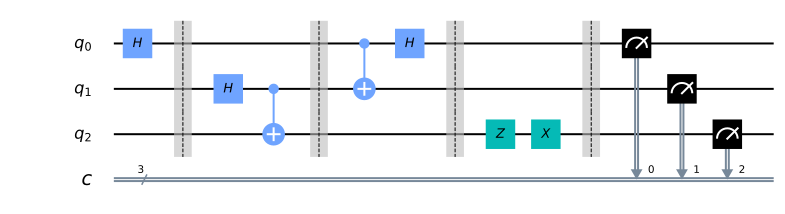

In [6]:
qc4 = QuantumCircuit(n, n)
apply_secret_unitary(secret_unitary, qc4.qubits[0], qc4, dagger = 0)
qc4.barrier()
qc4.h(1)
qc4.cx(1,2)
qc4.barrier()
qc4.cx(0,1)
qc4.h(0)
qc4.barrier()
qc4.z(2)
qc4.x(2)
qc4.barrier()
qc4.measure([0,1,2],[0,1,2])
qc4.draw(output='mpl')

In [7]:
# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

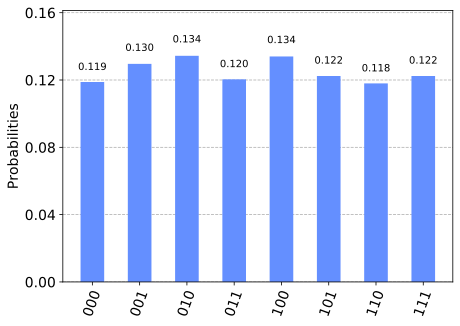

{'011': 301, '110': 295, '010': 336, '101': 306, '000': 297, '001': 324, '100': 335, '111': 306}
Done


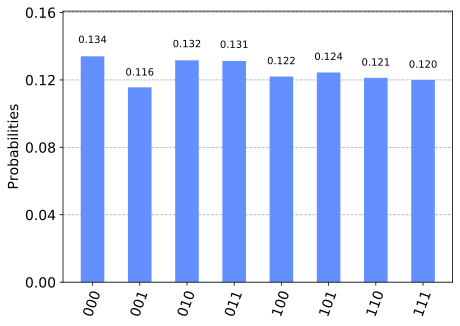

{'011': 328, '110': 303, '010': 329, '101': 311, '000': 335, '001': 289, '100': 305, '111': 300}
Done


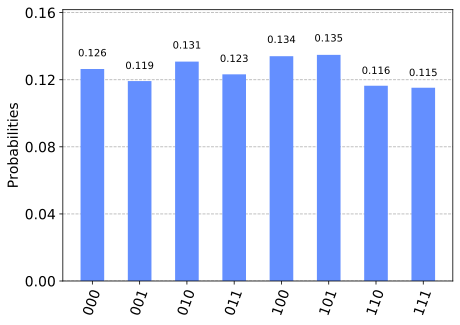

{'011': 308, '110': 291, '010': 327, '101': 337, '000': 316, '001': 298, '100': 335, '111': 288}
Done


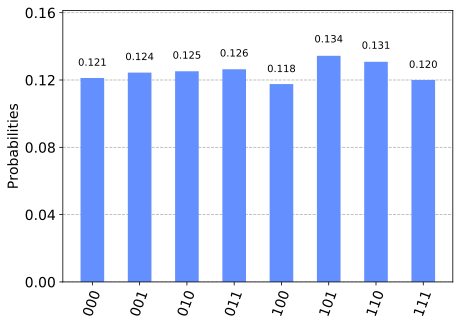

{'011': 316, '110': 327, '010': 313, '101': 336, '000': 303, '001': 311, '100': 294, '111': 300}
Done


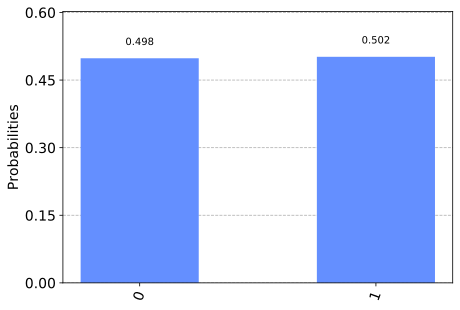

Job Status: job has successfully run


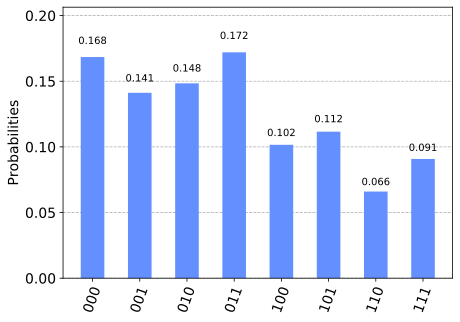

{'011': 430, '110': 165, '010': 371, '101': 279, '000': 421, '001': 353, '100': 254, '111': 227}
Done
Job Status: job has successfully run


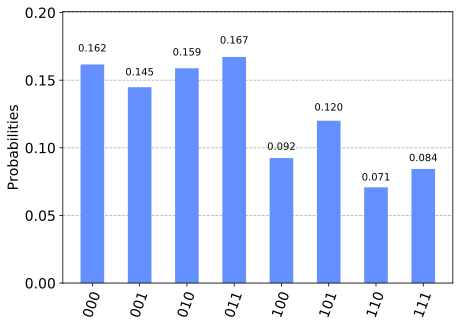

{'011': 418, '110': 177, '010': 397, '101': 300, '000': 404, '001': 362, '100': 231, '111': 211}
Done
Job Status: job has successfully run


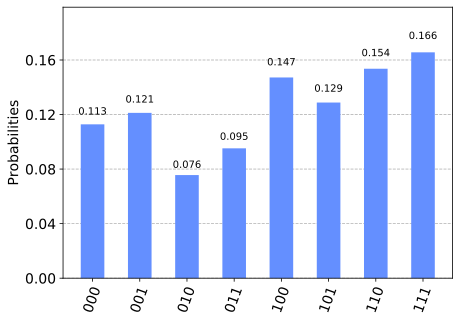

{'011': 238, '110': 384, '010': 189, '101': 322, '000': 282, '001': 303, '100': 368, '111': 414}
Done
Job Status: job has successfully run


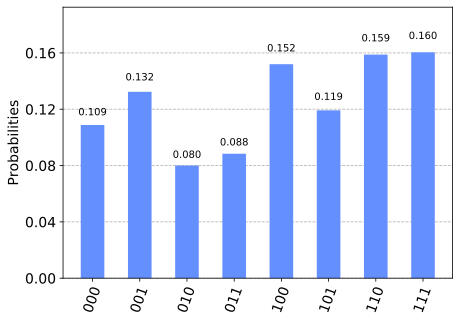

{'011': 221, '110': 397, '010': 200, '101': 298, '000': 272, '001': 331, '100': 380, '111': 401}
Done


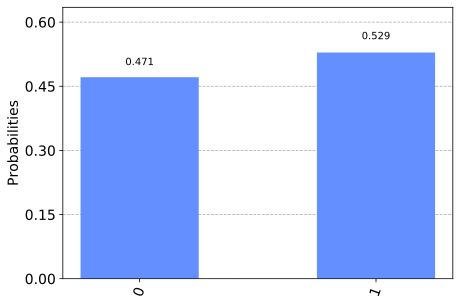

In [12]:
# transpile, plot circuit, run, plot result
backends = [ibmq_simulator, ibmq_device]

qcs = [qc1, qc2, qc3, qc4]
for be in backends:
    for qc in qcs:
        job = execute(qc, backend = be, shots=2500)
        if be == ibmq_device:
            job_monitor(job)
        bits = [ '100', '000', '111', '101', '011', '001', '110', '010']
        if qc == qc1:
            counts1 = job.result().get_counts()
            plot_histogram(counts1)
            for bit in bits:
                if bit not in counts1:
                    counts1[bit] = 0
            print(counts1)
        if qc == qc2:
            counts2 = job.result().get_counts()
            plot_histogram(counts2)
            for bit in bits:
                if bit not in counts2:
                    counts2[bit] = 0
            print(counts2)
        if qc == qc3:
            counts3 = job.result().get_counts()
            plot_histogram(counts3)
            for bit in bits:
                if bit not in counts3:
                    counts3[bit] = 0
            print(counts3)
        if qc == qc4:
            counts4 = job.result().get_counts()
            plot_histogram(counts4)
            for bit in bits:
                if bit not in counts4:
                    counts4[bit] = 0
            print(counts4)
        print('Done')
        ibmq_sim_results = job.result()
        ibmq_sim_counts = job.result().get_counts()
    if be == ibmq_simulator:
        countssim = {'0': counts1["000"]+counts2["001"]+counts3["010"]+counts4["011"],'1': counts1["100"]+counts2["101"]+counts3["110"]+counts4["111"]}
        plot_histogram(countssim)
    else:
        countsdev = {'0': counts1["000"]+counts2["001"]+counts3["010"]+counts4["011"],'1': counts1["100"]+counts2["101"]+counts3["110"]+counts4["111"]}
        plot_histogram(countsdev)
   


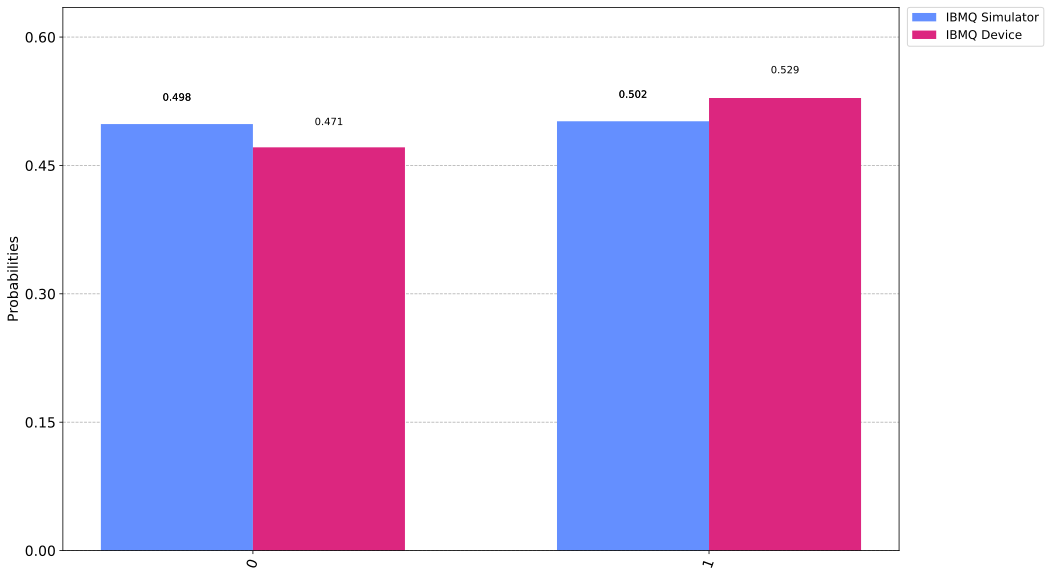

In [13]:
# plotting the results together
plot_histogram([countssim, countsdev],
               legend = ['IBMQ Simulator', 'IBMQ Device'],
               figsize = (15,10))